# Environment

In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from abc_atlas_access.abc_atlas_cache.abc_project_cache import AbcProjectCache

import os
import sys
# Set the current working directory
os.chdir('/beegfs/scratch/ric.broccoli/kubacki.michal/SRF_SRRM3')

from importlib import reload
from BrainAtlas.mouse.ac_create_scRNAseq_set_functions import *
reload(sys.modules['BrainAtlas.mouse.ac_create_scRNAseq_set_functions'])

<module 'BrainAtlas.mouse.ac_create_scRNAseq_set_functions' from '/beegfs/scratch/ric.broccoli/kubacki.michal/SRF_SRRM3/BrainAtlas/mouse/ac_create_scRNAseq_set_functions.py'>

In [9]:
pd.set_option('display.max_columns', None)

# Load data


In [106]:
# Analysis parameters
datasets = ['WMB-10Xv3']
genes = ['Srrm3', 'Srrm4'] # , 'Celsr3'
regions = ["MOp","SSp","HIP","STRd","MB","CB"]

In [2]:
%%capture
# Initialize cache
download_base = Path('./DATA/abc_atlas')
download_base.mkdir(parents=True, exist_ok=True)
abc_cache = AbcProjectCache.from_cache_dir(download_base)
abc_cache.load_latest_manifest()
abc_cache.current_manifest

In [5]:
# Load metadata with cluster annotations
cell_metadata = abc_cache.get_metadata_dataframe(
    directory='WMB-10X', 
    file_name='cell_metadata_with_cluster_annotation',
    low_memory=False  # Add low_memory=False to handle mixed dtype columns
)

In [8]:
cell_metadata.shape

(4042976, 28)

In [11]:
cell_metadata.head(3)

,cell_label,cell_barcode,barcoded_cell_sample_label,library_label,feature_matrix_label,entity,brain_section_label,library_method,region_of_interest_acronym,donor_label,donor_genotype,donor_sex,dataset_label,x,y,cluster_alias,neurotransmitter,class,subclass,supertype,cluster,neurotransmitter_color,class_color,subclass_color,supertype_color,cluster_color,region_of_interest_order,region_of_interest_color
0,GCGAGAAGTTAAGGGC-410_B05,GCGAGAAGTTAAGGGC,410_B05,L8TX_201030_01_C12,WMB-10Xv3-HPF,cell,NaN,10Xv3,RHP,Snap25-IRES2-Cre;Ai14-550850,Ai14(RCL-tdT)/wt,F,WMB-10Xv3,23.146826,-3.086639,1,Glut,01 IT-ET Glut,018 L2 IT PPP-APr Glut,0082 L2 IT PPP-APr Glut_3,0326 L2 IT PPP-APr Glut_3,#2B93DF,#FA0087,#0F6632,#266DFF,#64661F,15,#CCB05C
1,AATGGCTCAGCTCCTT-411_B06,AATGGCTCAGCTCCTT,411_B06,L8TX_201029_01_E10,WMB-10Xv3-HPF,cell,NaN,10Xv3,RHP,Snap25-IRES2-Cre;Ai14-550851,Ai14(RCL-tdT)/wt,F,WMB-10Xv3,23.138481,-3.022000,1,Glut,01 IT-ET Glut,018 L2 IT PPP-APr Glut,0082 L2 IT PPP-APr Glut_3,0326 L2 IT PPP-APr Glut_3,#2B93DF,#FA0087,#0F6632,#266DFF,#64661F,15,#CCB05C
2,AACACACGTTGCTTGA-410_B05,AACACACGTTGCTTGA,410_B05,L8TX_201030_01_C12,WMB-10Xv3-HPF,cell,NaN,10Xv3,RHP,Snap25-IRES2-Cre;Ai14-550850,Ai14(RCL-tdT)/wt,F,WMB-10Xv3,23.472557,-2.992709,1,Glut,01 IT-ET Glut,018 L2 IT PPP-APr Glut,0082 L2 IT PPP-APr Glut_3,0326 L2 IT PPP-APr Glut_3,#2B93DF,#FA0087,#0F6632,#266DFF,#64661F,15,#CCB05C


In [ ]:
cell_metadata.set_index('cell_label', inplace=True)

In [107]:
# Load expression data
expression_data, metadata = load_multi_region_data(
    cell_metadata=cell_metadata,
    abc_cache=abc_cache,
    datasets=datasets,
    genes=genes,
    dataset_regions=regions
)

/beegfs/scratch/ric.broccoli/kubacki.michal/conda_envs/jupyter_nb/lib/python3.9/site-packages/abc_atlas_access/abc_atlas_cache/abc_project_cache.py:429: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(path, **kwargs)


Processing WMB-10Xv3-HPF
Found 84264 cells in WMB-10Xv3-HPF
Processing WMB-10Xv3-Isocortex-1
Found 76033 cells in WMB-10Xv3-Isocortex-1
Processing WMB-10Xv3-STR
Found 55626 cells in WMB-10Xv3-STR
Processing WMB-10Xv3-MB
Found 337101 cells in WMB-10Xv3-MB
Processing WMB-10Xv3-CB
Found 181723 cells in WMB-10Xv3-CB
Processing WMB-10Xv3-Isocortex-2
Found 48468 cells in WMB-10Xv3-Isocortex-2


In [109]:
# Merge expression_data with metadata using the index (cell_label)
combined_data = expression_data.join(metadata, how='inner')

# Verify the merge worked by checking the shape and first few rows
print(f"Combined data shape: {combined_data.shape}")
print("\nFirst few rows of combined data:")
combined_data.head(3)

Combined data shape: (783215, 31)

First few rows of combined data:


,Srrm4,Srrm3,region,dataset,cell_barcode,barcoded_cell_sample_label,library_label,feature_matrix_label,entity,brain_section_label,library_method,region_of_interest_acronym,donor_label,donor_genotype,donor_sex,dataset_label,x,y,cluster_alias,neurotransmitter,class,subclass,supertype,cluster,neurotransmitter_color,class_color,subclass_color,supertype_color,cluster_color,region_of_interest_order,region_of_interest_color
AGCGATTGTATTCCGA-419_B05,6.64194,7.528342,HIP,WMB-10Xv3,AGCGATTGTATTCCGA,419_B05,L8TX_201106_01_E04,WMB-10Xv3-HPF,cell,NaN,10Xv3,HIP,Snap25-IRES2-Cre;Ai14-551016,Ai14(RCL-tdT)/wt,M,WMB-10Xv3,12.248370,12.191566,678,GABA,06 CTX-CGE GABA,048 RHP-COA Ndnf Gaba,0193 RHP-COA Ndnf Gaba_1,0687 RHP-COA Ndnf Gaba_1,#FF3358,#CCFF33,#0003FF,#5CCC7F,#661F40,14,#FF8F00
TCGCAGGGTTCTATCT-420_A06,0.00000,0.000000,HIP,WMB-10Xv3,TCGCAGGGTTCTATCT,420_A06,L8TX_201106_01_F03,WMB-10Xv3-HPF,cell,NaN,10Xv3,HIP,Snap25-IRES2-Cre;Ai14-551017,Ai14(RCL-tdT)/wt,M,WMB-10Xv3,3.562847,22.757886,14939,NaN,30 Astro-Epen,319 Astro-TE NN,1163 Astro-TE NN_3,5225 Astro-TE NN_3,#666666,#594a26,#3DCCB1,#a8afa5,#551799,14,#FF8F00
CCCTCAATCTAACGGT-444_A04,0.00000,0.000000,HIP,WMB-10Xv3,CCCTCAATCTAACGGT,444_A04,L8TX_201204_01_C02,WMB-10Xv3-HPF,cell,NaN,10Xv3,HIP,Snap25-IRES2-Cre;Ai14-553680,Snap25-IRES2-Cre/wt;Ai14(RCL-tdT)/wt,M,WMB-10Xv3,5.853670,23.995227,14939,NaN,30 Astro-Epen,319 Astro-TE NN,1163 Astro-TE NN_3,5225 Astro-TE NN_3,#666666,#594a26,#3DCCB1,#a8afa5,#551799,14,#FF8F00


# Filter data

In [110]:
print(combined_data.shape)
combined_data = combined_data[combined_data.neurotransmitter.notna()]
print(combined_data.shape)


(783215, 31)
(533041, 31)


In [111]:
print(metadata.library_method.unique())
print(metadata.feature_matrix_label.unique())


['10Xv3']
['WMB-10Xv3-HPF' 'WMB-10Xv3-Isocortex-1' 'WMB-10Xv3-STR' 'WMB-10Xv3-MB'
 'WMB-10Xv3-CB' 'WMB-10Xv3-Isocortex-2']


In [112]:
for region in sorted(combined_data.region_of_interest_acronym.unique()):
    print(f"\n=== Region: {region} ===")
    
    region_data = combined_data[combined_data.region_of_interest_acronym == region]
    
    print("\nClass counts (total elements: {}):".format(len(region_data["class"].unique())))
    class_counts = region_data["class"].value_counts().sort_values(ascending=False)
    for class_name, count in list(class_counts.items())[:10]:
        print(f"{class_name}: {count}")

    print("\nSubclass counts (total elements: {}):".format(len(region_data["subclass"].unique())))
    subclass_counts = region_data["subclass"].value_counts().sort_values(ascending=False)
    for subclass_name, count in list(subclass_counts.items())[:10]:
        print(f"{subclass_name}: {count}")

    print("\nSupertype counts (total elements: {}):".format(len(region_data["supertype"].unique())))
    supertype_counts = region_data["supertype"].value_counts().sort_values(ascending=False)
    for supertype_name, count in list(supertype_counts.items())[:10]:
        print(f"{supertype_name}: {count}")

    print("\nCluster counts (total elements: {}):".format(len(region_data["cluster"].unique())))
    cluster_counts = region_data["cluster"].value_counts().sort_values(ascending=False)
    for cluster_name, count in list(cluster_counts.items())[:10]:
        print(f"{cluster_name}: {count}")



=== Region: CB ===

Class counts (total elements: 8):
29 CB Glut: 114327
28 CB GABA: 48098
27 MY GABA: 3594
24 MY Glut: 260
19 MB Glut: 97
20 MB GABA: 85
23 P Glut: 26
26 P GABA: 4

Subclass counts (total elements: 33):
314 CB Granule Glut: 113841
311 CBX MLI Megf11 Gaba: 30795
312 CBX MLI Cdh22 Gaba: 12805
309 CB PLI Gly-Gaba: 4223
295 CBN Dmbx1 Gaba: 3574
315 DCO UBC Glut: 486
250 CBN Neurod2 Pvalb Glut: 259
310 CBX Golgi Gly-Gaba: 242
181 IC Tfap2d Maf Glut: 91
198 IC Six3 En2 Gaba: 60

Supertype counts (total elements: 53):
1155 CB Granule Glut_2: 113757
1149 CBX MLI Megf11 Gaba_1: 30428
1151 CBX MLI Cdh22 Gaba_1: 12805
1115 CBN Dmbx1 Gaba_1: 3574
1144 CB PLI Gly-Gaba_1: 3554
1156 DCO UBC Glut_1: 486
1150 CBX MLI Megf11 Gaba_2: 367
1147 CB PLI Gly-Gaba_4: 336
1003 CBN Neurod2 Pvalb Glut_1: 259
1145 CB PLI Gly-Gaba_2: 251

Cluster counts (total elements: 112):
5201 CB Granule Glut_2: 113580
5188 CBX MLI Megf11 Gaba_1: 30326
5192 CBX MLI Cdh22 Gaba_1: 12805
5000 CBN Dmbx1 Gaba_1: 34

In [113]:
# Create dictionary to store region dataframes
region_dfs = {}

for region in sorted(combined_data.region_of_interest_acronym.unique()):
    # Get data for this region
    region_data = combined_data[combined_data.region_of_interest_acronym == region]
    
    # Get class counts and filter for >200
    class_counts = region_data["class"].value_counts()
    classes_over_200 = class_counts[class_counts > 200].index
    
    # Filter region data to only keep classes with >200 cells
    filtered_region_data = region_data[region_data["class"].isin(classes_over_200)]
    
    # Store filtered dataframe in dictionary
    region_dfs[region] = filtered_region_data


# Plots


## Plot by class

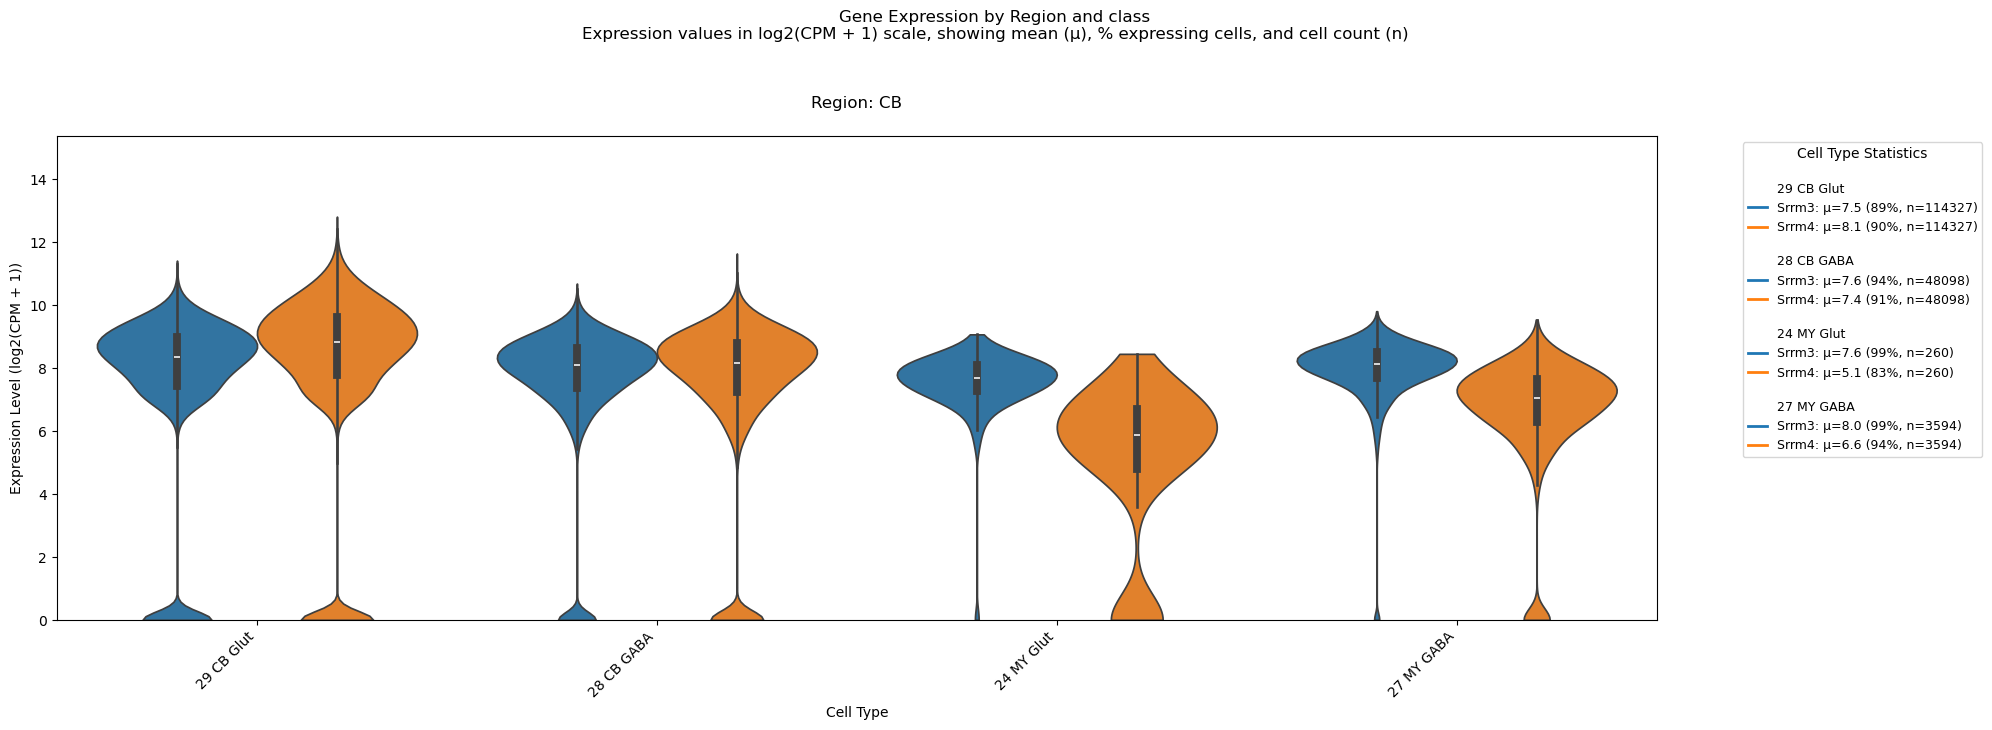

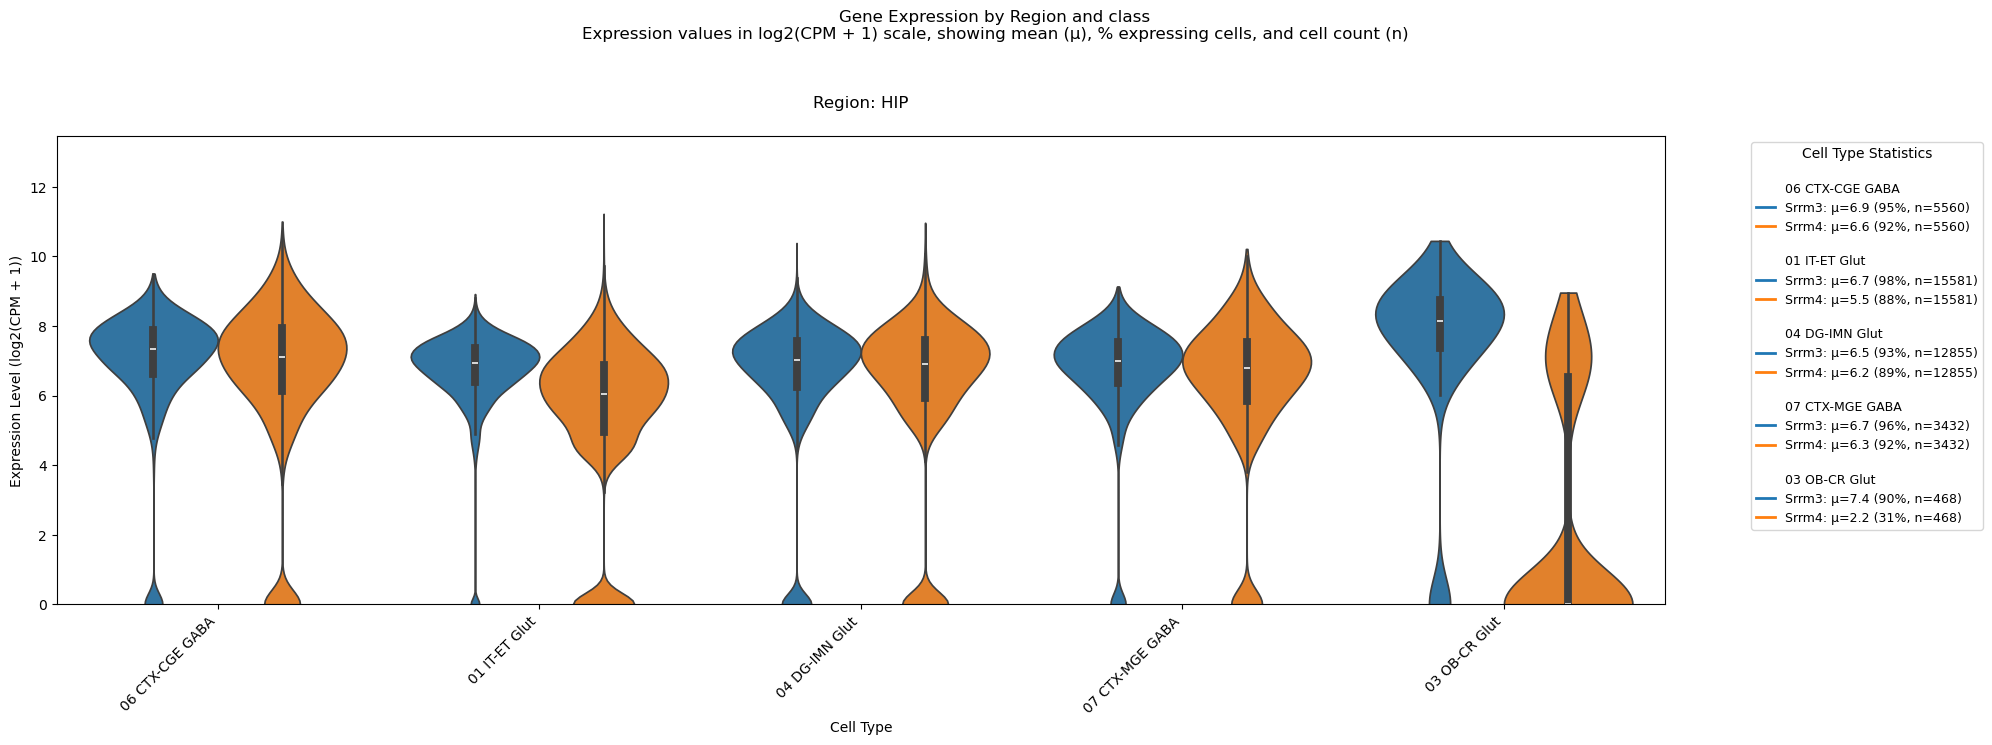

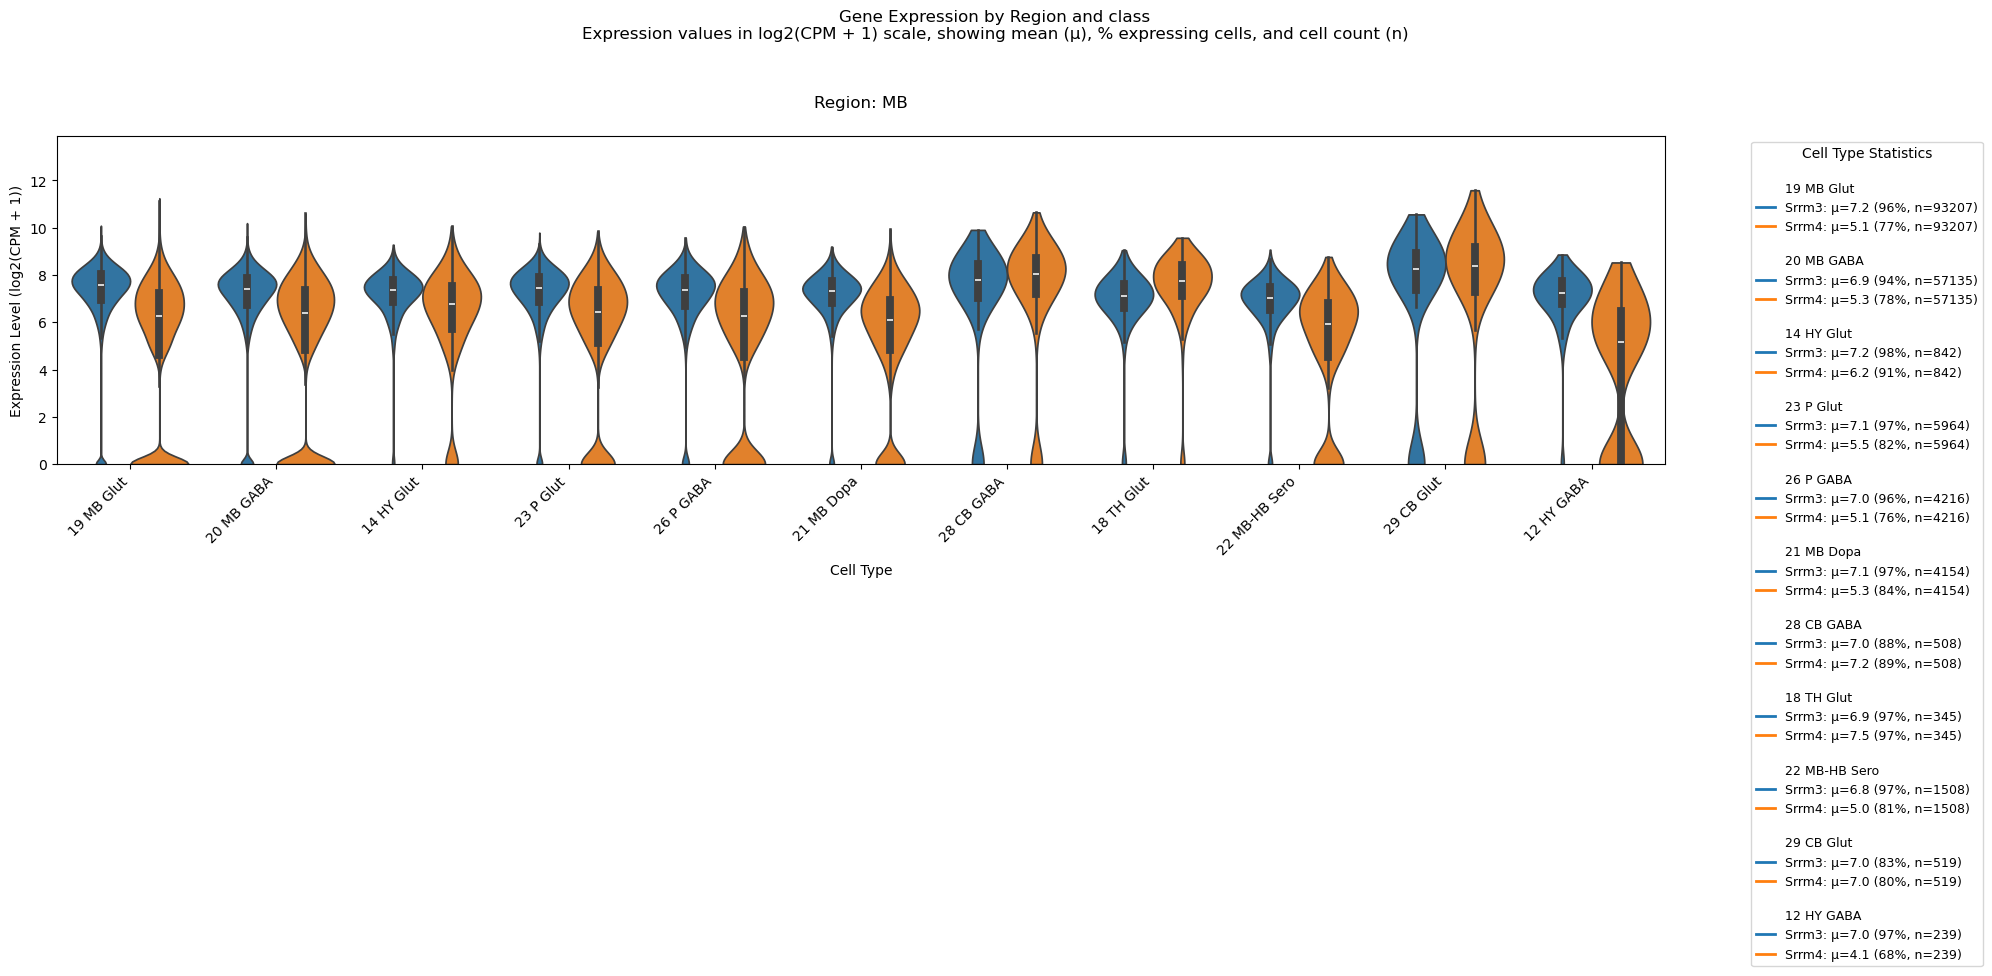

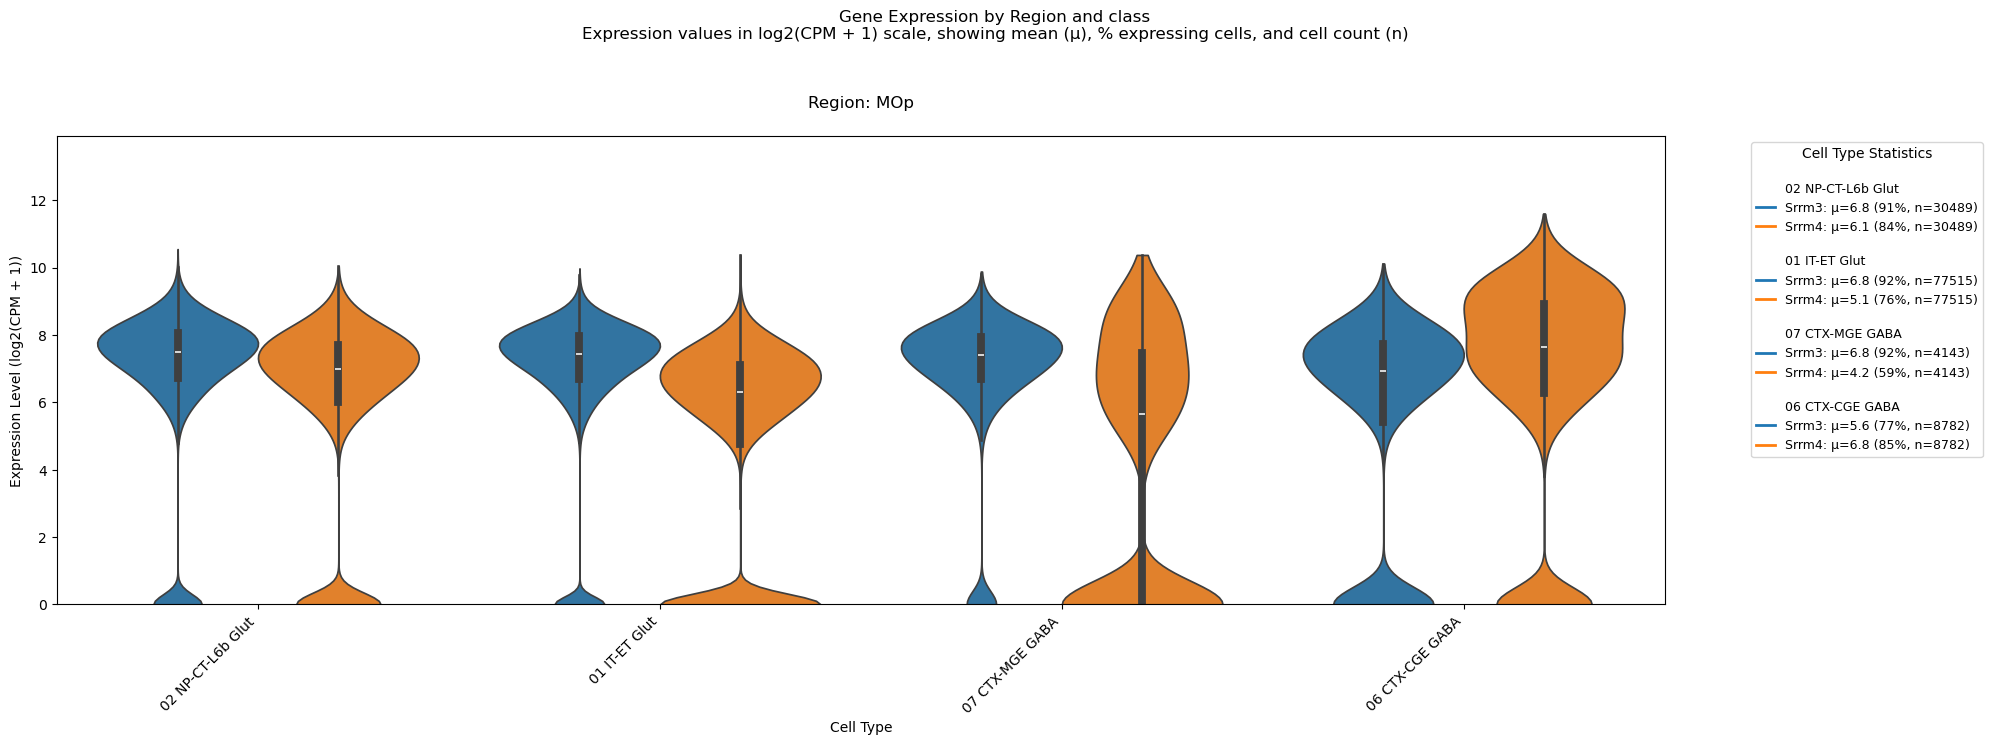

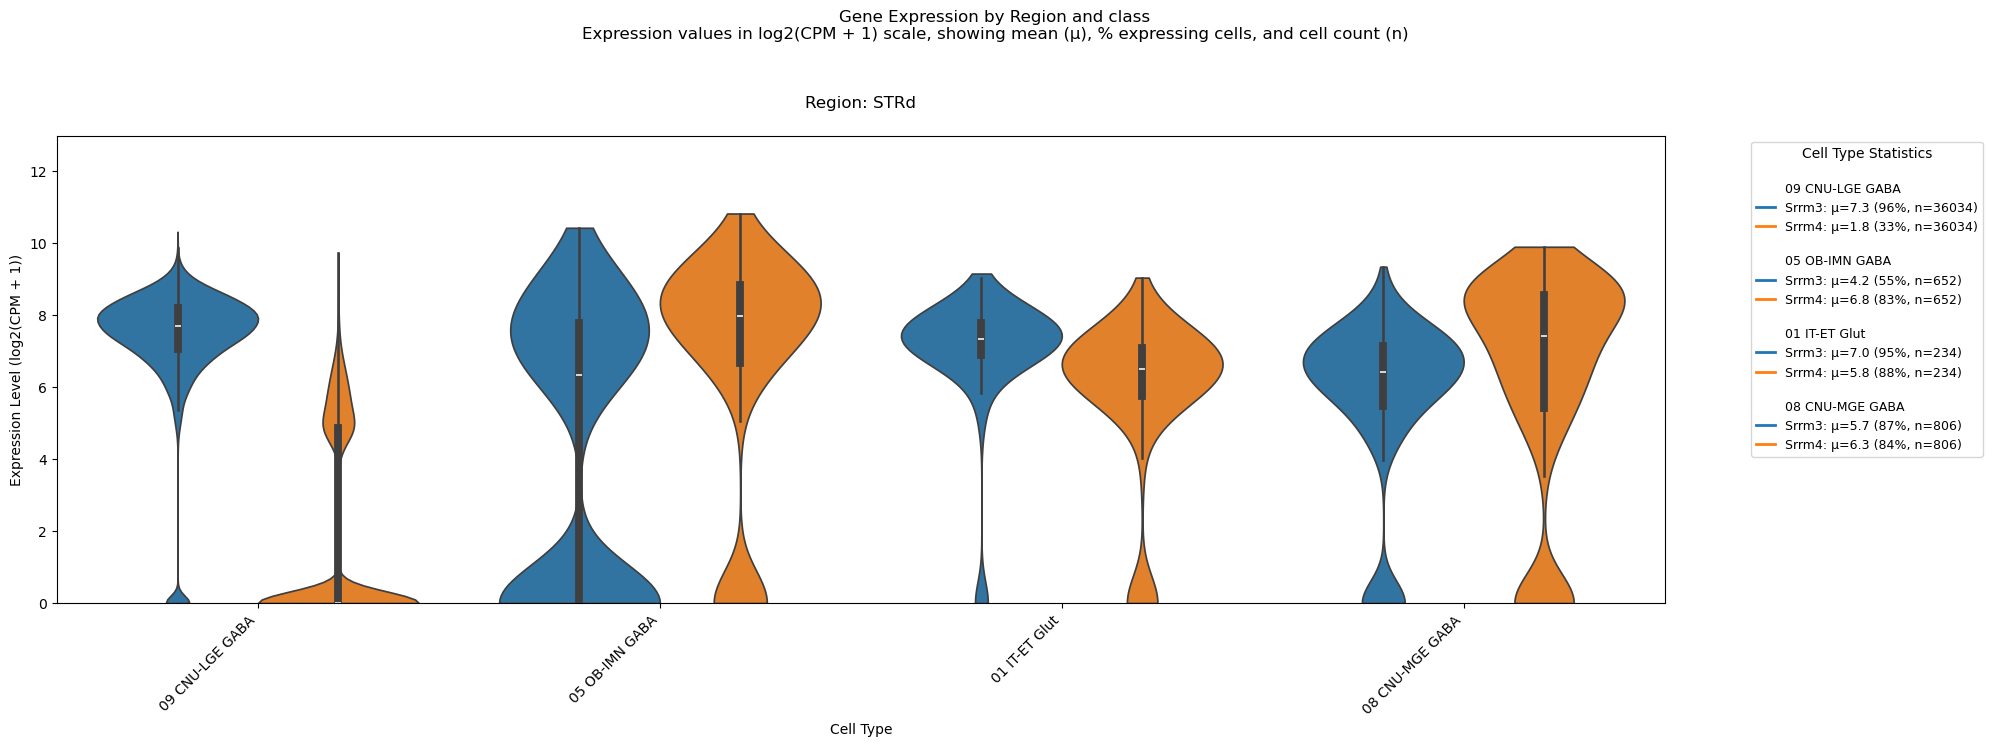

In [114]:
# Create plots to visualize expression by class for each region
for region, filtered_region_data in region_dfs.items(): #  list(region_dfs.items())[:1]
    # Plot using the plot_combined_gene_expression function 
    fig, axes, stats = plot_combined_gene_expression(filtered_region_data,
                                                   group_by='class',
                                                   genes=['Srrm3', 'Srrm4'])
    plt.show()


## Plot by neurotransmitter

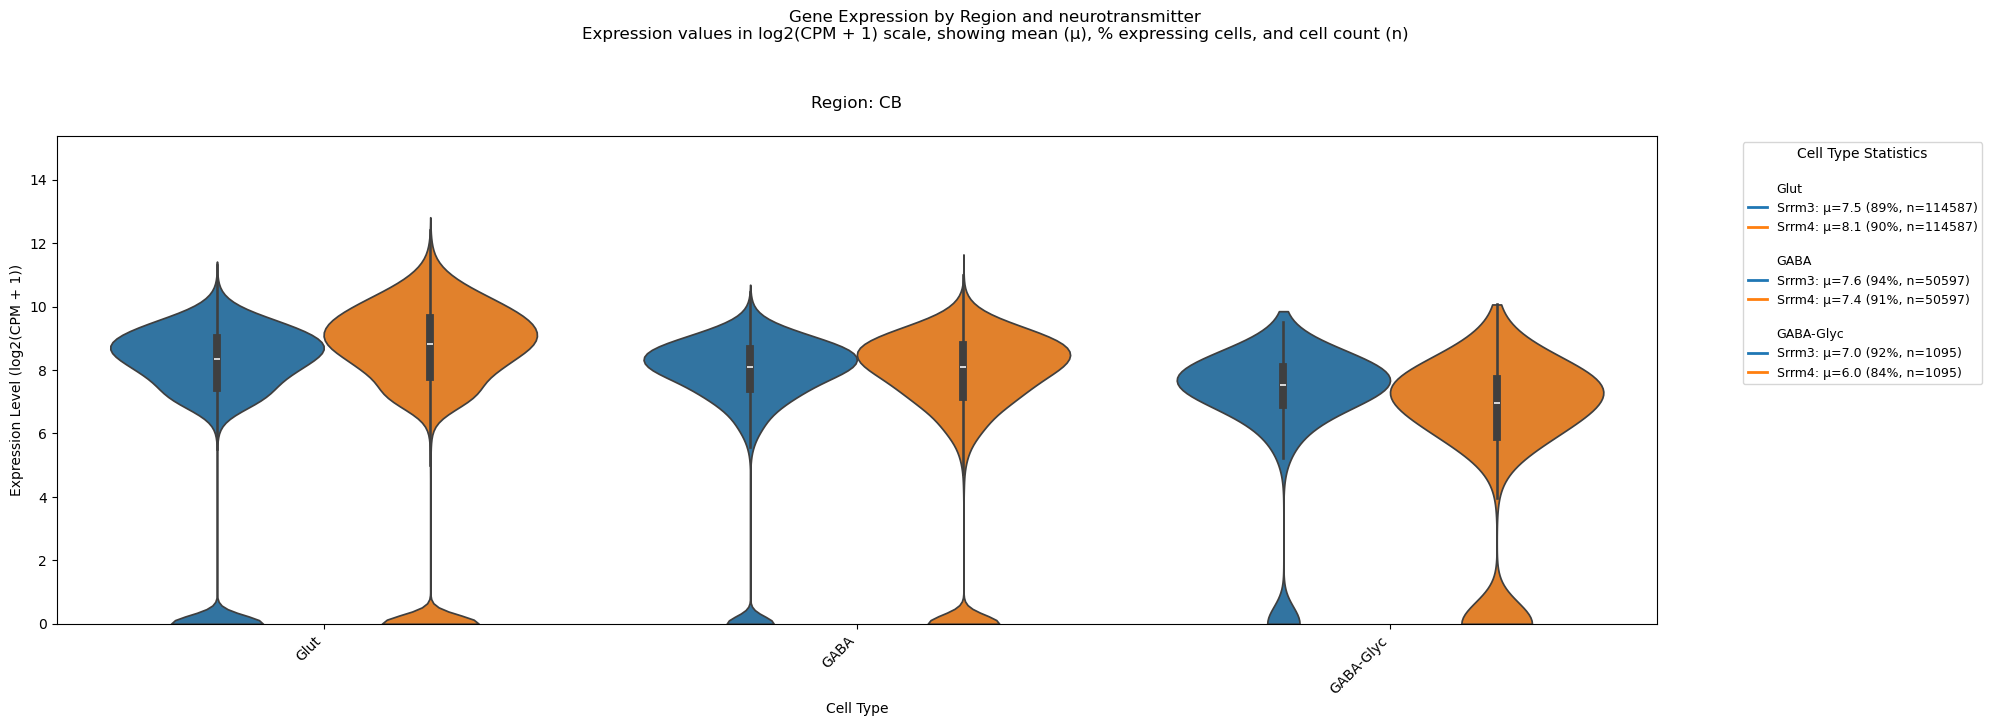

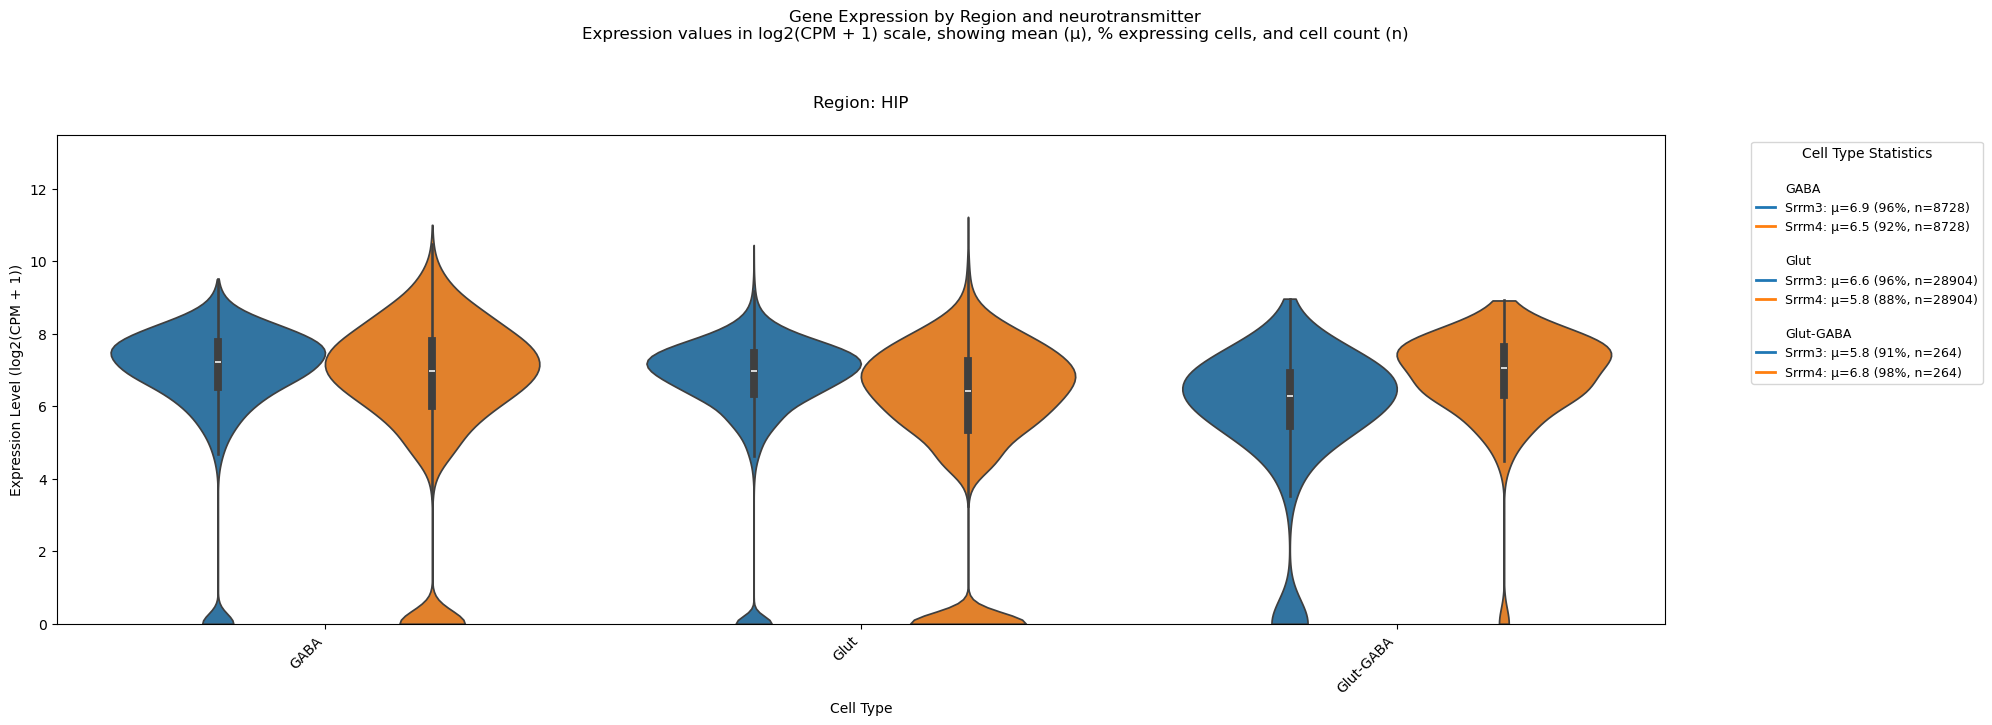

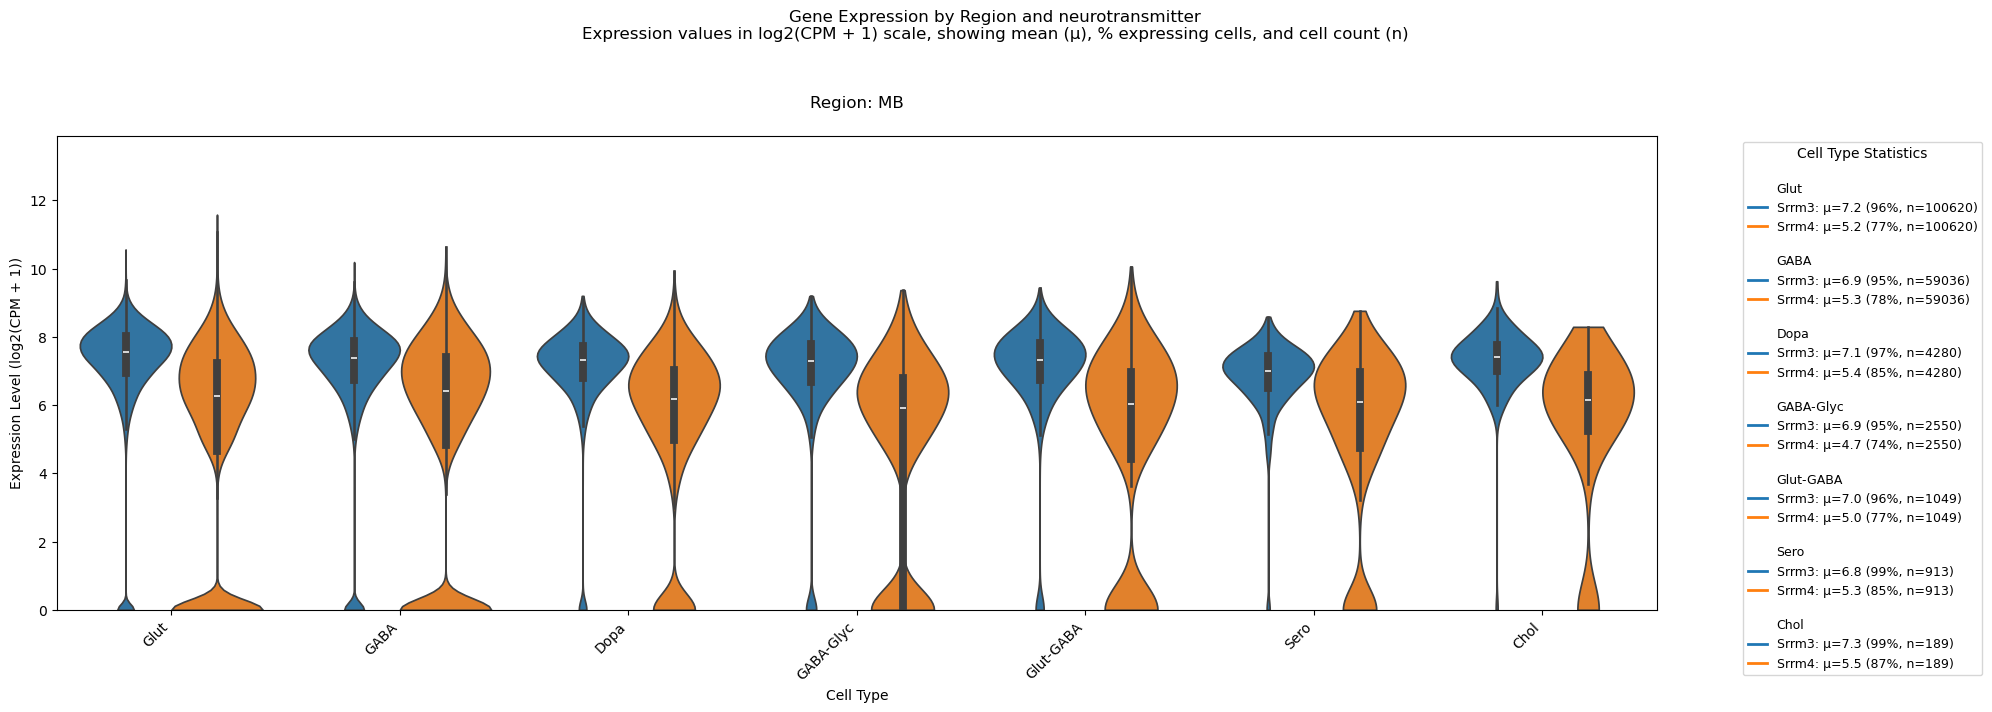

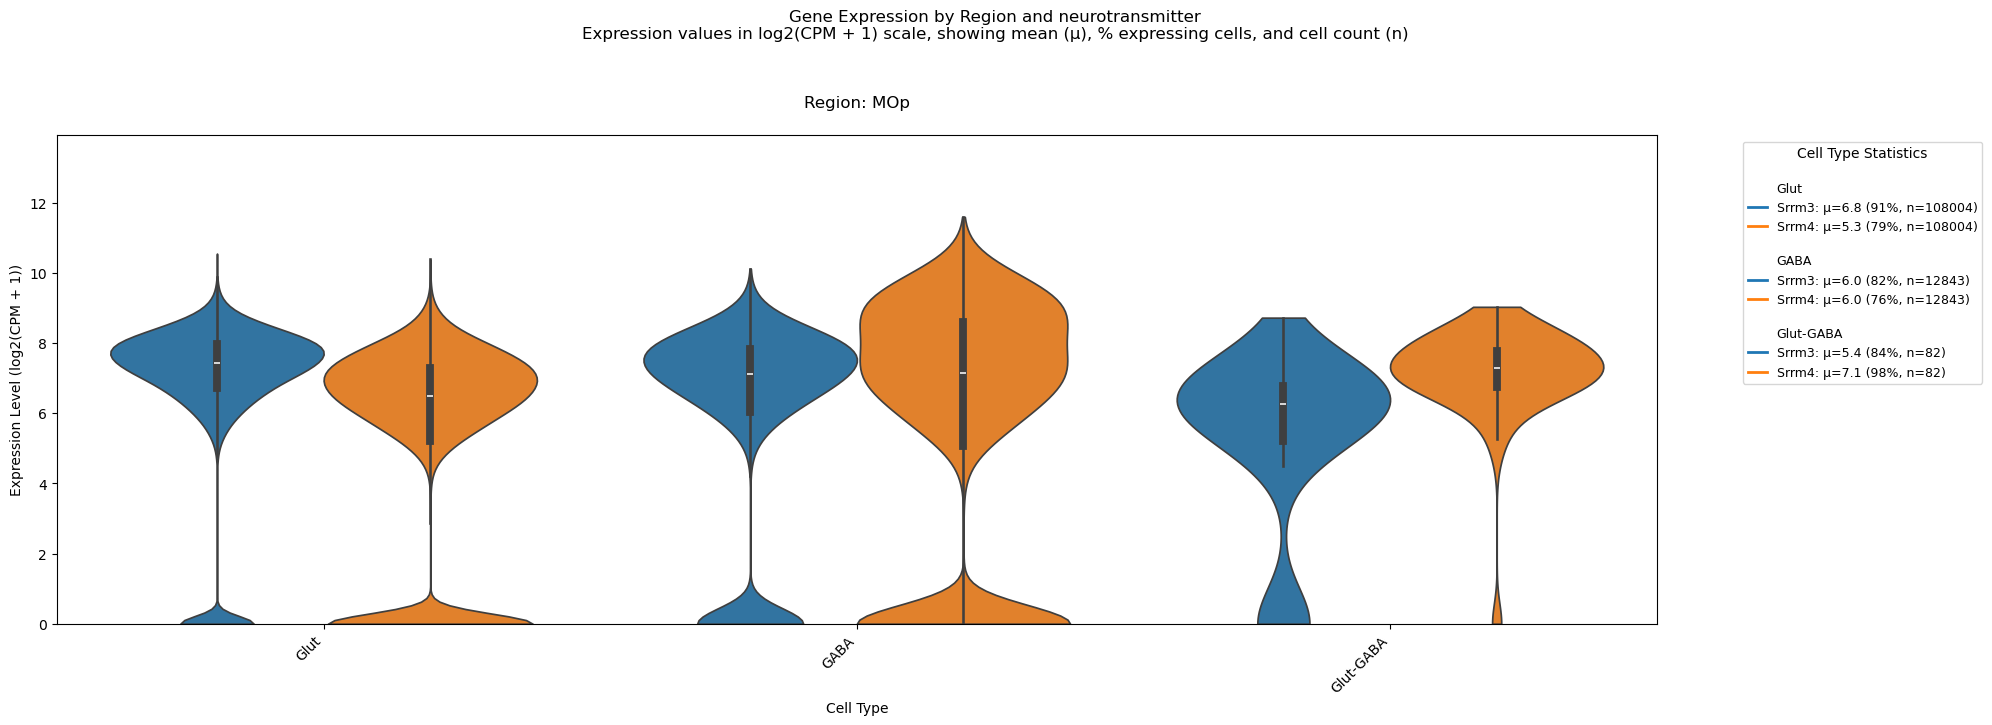

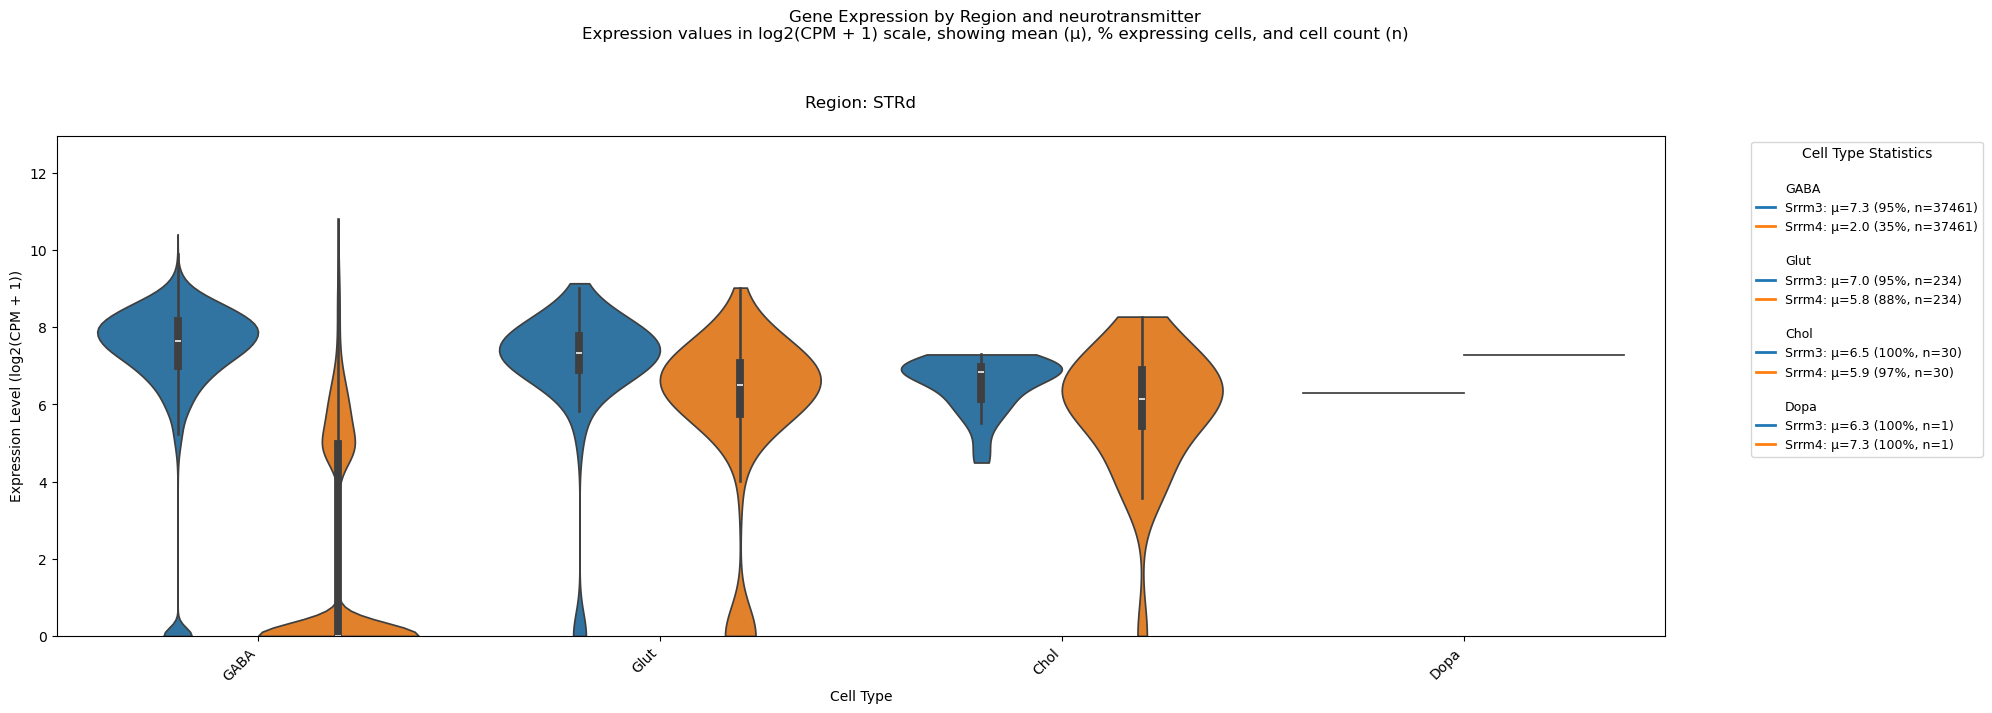

In [115]:
# Create plots to visualize expression by class for each region
for region, filtered_region_data in region_dfs.items(): #  list(region_dfs.items())[:1]
    # Plot using the plot_combined_gene_expression function 
    fig, axes, stats = plot_combined_gene_expression(filtered_region_data,
                                                   group_by='neurotransmitter',
                                                   genes=['Srrm3', 'Srrm4'])
    plt.show()
